 #  第 7 章 高斯过程

<style>p{text-indent:2em;2}</style>

在上一章中，我们学习了狄利克雷过程，它是狄利克雷分布的无限维推广，可用于设置未知连续分布的先验。在本章中，我们将学习高斯过程，这是高斯分布的无限维推广，可用于设置未知函数的先验。在贝叶斯统计中，狄利克雷过程和高斯过程都被用来建立灵活的模型，其中允许参数的数量随着数据的大小而增加。

本章我们将学习：

- 函数作为概率对象
- 核
- 具有高斯似然的高斯过程
- 具有非高斯似然的高斯过程

---

## 7.1 线性模型和非线性数据

在第3章 “线性回归建模” 和 第4章 “广义线性回归模型” 中，介绍了如何构建一般形式的模型：


```{math}
\theta=\psi(\phi(X) \beta) \tag{式7.1} \label{式7.1}
```

 $\eqref{式7.1}$ 中， $\theta$ 是因变量概率分布的某个参数，如高斯分布的平均值 $\mu$ 、二项式的参数 $p$、泊松分布的比率 $\lambda$ 等。$\psi$ 为逆连接函数，$\phi$ 是平方根或多项式函数，$\beta$ 为线性回归的权重参数。对于最简单的一元线性回归情况，$\psi$ 为恒等函数。

对上述贝叶斯模型的拟合可以视为通过推断得到权重参数 $\beta$ 的后验分布，因此，被称为估计的`权重视角（Weight View）`。以多项式回归为例，通过设计非线性函数 $\phi$ ，可将输入映射到特征空间，然后在特征空间中拟合一个在实际空间中非线性的线性关系。理论上通过使用适当阶次的多项式，总是可以完美拟合任何函数。但除非应用一定形式的正则化（如使用强先验），否则多项式回归很容易导致过拟合，进而模型泛化能力变差。

`高斯过程` 让数据决定函数的复杂度，在避免（或最小化）过拟合问题同时，为任意函数的建模提供了理论解决方案，为复杂问题建模提供了一种 `函数视角 （Function View）` 。

以下各节从实用角度解释了高斯过程，几乎避免了所有数学知识。有关更正式的解释，请查看`第 9 章 『下一步去哪里？』`中列出的资源。

## 7.2 对函数建模

 我们将首先描述一种将函数表示为概率对象的方法，以开始对高斯过程的讨论。可以把函数 $f$ 看作是从一组输入 $x$ 到一组输出 $y$ 的映射。因此，可以这样写：

```{math}
y=f(x) \tag{式7.2} \label{式7.2}
```

表示函数的一种方式是为每个值 $x_i$ 列出其相应值 $y_i$ 。事实上，你可能还记得小时候这种函数的表示方式：

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505201816_b3.webp)

</center>

一般情况下，$x$ 和 $y$ 的值将位于实数行上；因此，可将函数视为成对$( x_i,y_i)$ 值的（可能）无限有序列表。这里顺序非常重要，打乱顺序将代表不同函数。

函数也可以表示为一个由 $x$ 值索引的（可能）无限数组，但重要区别在于，$x$ 值不限于整数，可以取实数。

采用这种描述方式，可以表示任何想要的函数。但如果想要表示函数的概率呢（例如：混合模型中的多个组分分别对应一个概率分布函数，通过描述函数的概率分布似乎可以对混合模型建模）？我们可以通过让映射具有概率性质来实现。让每个 $y_i$ 的值都是一个随机变量，该随机变量服从给定均值和方差的高斯分布。通过该方式，不再是对单个特定函数的描述，而形成对一系列分布族的描述。

为了使讨论具体化，让我们使用一些 Python 代码来构建和绘制这类函数的两个示例：

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

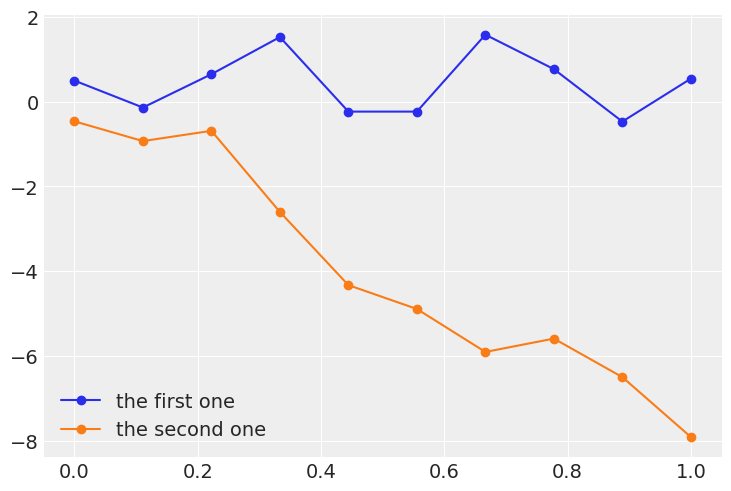

In [2]:
np.random.seed(42)
# 曲线1：10个预测变量，10个高斯采样的结果变量
x = np.linspace(0, 1, 10)
y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label='the first one')

# 曲线2：相同的10个预测变量，10个采用了不同均值高斯采样的结果变量
y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')
plt.legend()

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505202243_46.webp)

图 7.1
</center>

图 7.1 显示，使用高斯分布的样本对函数进行编码并不复杂。但用于生成图 7.1 的方法有限且不够灵活。我们期望实函数具有某种结构或模式，但第一种函数表达方式无法编码数据点之间的关系。事实上，由于实验是从一维高斯分布中获得了 10 个独立样本，所以数据点之间完全独立。对于第二个函数，实验引入了一些依赖关系，将点 $y_{i+1}$ 的均值设置为 $y_i$ 的值，使得数据点之间有了某种依赖关系，进而为编码预期的函数提供了思路。而本章后续内容，将介绍一种更通用的方法来捕获这种依赖，而且不仅限于相邻点之间。

此处使用高斯分布的主要原因是它具备指定任何形状函数的灵活性，因为每个点都有自己的均值和方差；其次从数学角度看，高斯分布具有一些非常好的特性。

### 7.2.1 多维高斯与函数

在图 7.1 中，我们使用一维高斯的 $n$ 个样本来表示一个函数。其实，还可以换一种方式思考：既然每个数据点均被视为来自特定高斯分布的一个采样，是否可以将连续 $n$ 个数据点视为一个来自于 $n$ 维高斯分布的采样呢？ 更进一步的，如果样本数量无限大，是否可以用一个无限维高斯分布来对其建模呢？

答案是肯定的。 在每个数据点均为独立的高斯分布样本假设下，可以使用 $n$ 维高斯分布来对连续 $n$ 个数据点进行建模，而此样本则可以视为 $n$ 维高斯分布的一个向量形式（长度为 $n$ ）的抽样。如果预测变量 $x$ 代表时间，则该模型就表示了一个基于高斯的随机过程，即高斯过程。

通过上述分析，大家会发现高斯过程本质上是一个无限维高斯分布（虽然实践种中通常是有限维的），它的每一维的边缘概率密度都是高斯分布，也代表着每个数据点都是来自某个一维高斯分布的抽样。

在 PyMC3 中，通过使用 `np.random.multivariate_normal(np.zeros_like(x), np.eye(len(x)))` 替换 `np.random.normal(0, 1, len(x))` ，即可生成与图 7.1 相同的图形。也证明了上述分析。

将模型视为多维高斯分布有一个比较大的优势，即可以利用协方差矩阵来编码数据点之间的相关性信息，进而打破观测独立性假设，为数据点间的依赖关系建模。例如，PyMC3 允许协方差矩阵为单位矩阵 `np.eye(len(X))`，表示图中 10 个数据点的方差为 1，而协方差为 0（因为观测独立性假设）。如果用其他正数替换单位矩阵中的零，则可能反映了另外一个完全不同的故事。

该也意味着，要以概率方式对函数建模，可能需要打破观测独立性假设，通过选择合适的协方差矩阵，来构造一个能够反映函数特征的多维高斯分布（或高斯过程）。

### 7.2.2 协方差函数与核

书接上文，与其他无限维高斯分布不同，高斯过程的维度间是有序的。某个维度与其相邻维度之间可能会存在某种关系，在此我们成这种关系为相关性。从数学上，反映不同变量之间相关性的主要工具是协方差矩阵（此处不展开，请参阅相关文献）。设想一下，如果通过某种方式，结合样本数据，量化了某个高斯过程中相邻维度间的特殊依赖关系，是否就完成了对该高斯过程的建模？

在实际工作中，协方差矩阵是用 `核函数` 指定的。也就是说，对高斯过程的建模转变为了对核函数的建模。出于讨论目的，此处简化地定义核函数为一个对称函数，它接受两个输入，当两个输入相同时返回 1 否则返回一个 [0,1) 间的正值。如果该条件满足，可将核函数的输出解释为两个输入之间的相似性度量，并用于构造协方差矩阵。

在众多可用的核中，指数族二次核是比较常用的一种：

```{math}
K\left(x, x^{\prime}\right)=\exp \left(-\frac{\left\|x-x^{\prime}\right\|^{2}}{2 \ell^{2}}\right) \tag{式7.3} \label{式7.3}
```

此处， $x,x'$是随机变量的值， $\left\|x-x^{\prime}\right\|^{2}$ 为平方欧氏距离：

```{math}
\left\|x-x^{\prime}\right\|^{2}=\left(x_{1}-x_{1}^{\prime}\right)^{2}+\left(x_{2}-x_{2}^{\prime}\right)^{2}+\cdots+\left(x_{n}-x_{n}^{\prime}\right)^{2} \tag{式7.4} \label{式7.4}
```

乍一看可能不明显，但指数族二次核具有与高斯分布类似的公式（见表达式 1.3)。因此，您可能会发现有人将此核称为高斯核。 $\ell$ 为长度尺度（或带宽、方差），用于控制核的宽度。

为更好地理解核的作用，定义一个 Python 函数来计算指数族二次核：

In [3]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

以下代码和图 7.2 旨在展示了一个 $4 \times 4$ 协方差矩阵。此处选择的输入相当简单，由值 [-1，0，1，2] 组成。

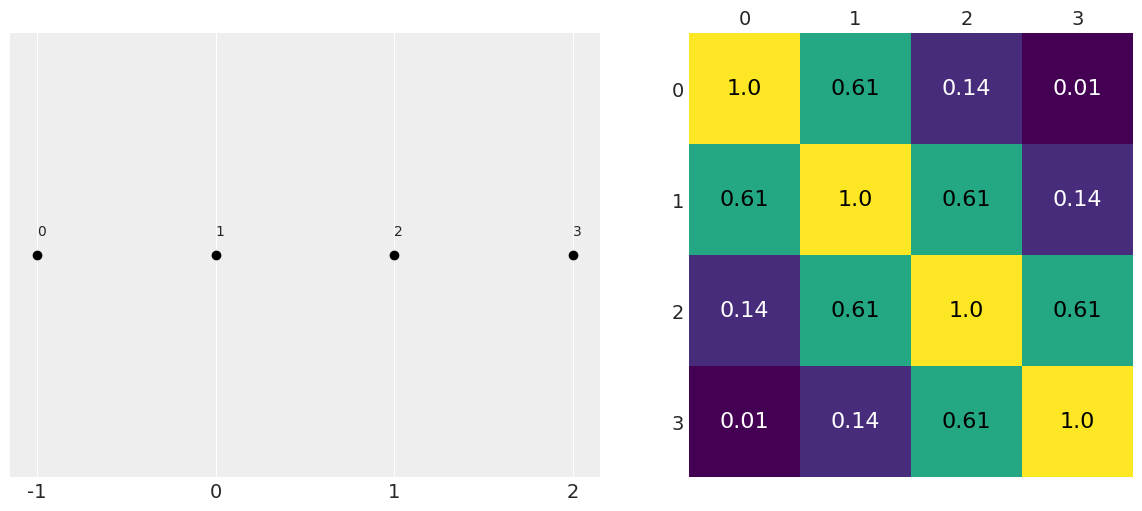

In [4]:
data = np.array([-1, 0, 1, 2])
cov = exp_quad_kernel(data, data, 1)
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)
ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)
ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505203138_6f.webp)

图 7.2
</center>

图 7.2 左侧显示了输入，x 轴上的值表示每个数据点的值，文本注释显示数据点的顺序（从零开始）。右侧有一个热图，表示使用指数族二次核获得的协方差矩阵。颜色越浅协方差越大。热图是对称的，对角线取值较大。协方差矩阵中每个元素的值与两点间距离成反比，而对角线为每个数据点自身比较的结果。

```{tip}
该核将数据点沿 x 轴的距离转换为预期函数值的协方差值。因此，x 轴上的两个点越近，预计它们在 y 轴上的值就越相似。
```

总之，我们可以使用具有给定协方差的多维高斯分布对函数建模，而使用核对协方差建模，如下例中，使用 `exp_quad_kernel` 函数来定义了一个多维高斯分布的协方差矩阵，然后使用该分布中的样本来表示函数：

Text(-0.03, 0.5, 'f(x)')

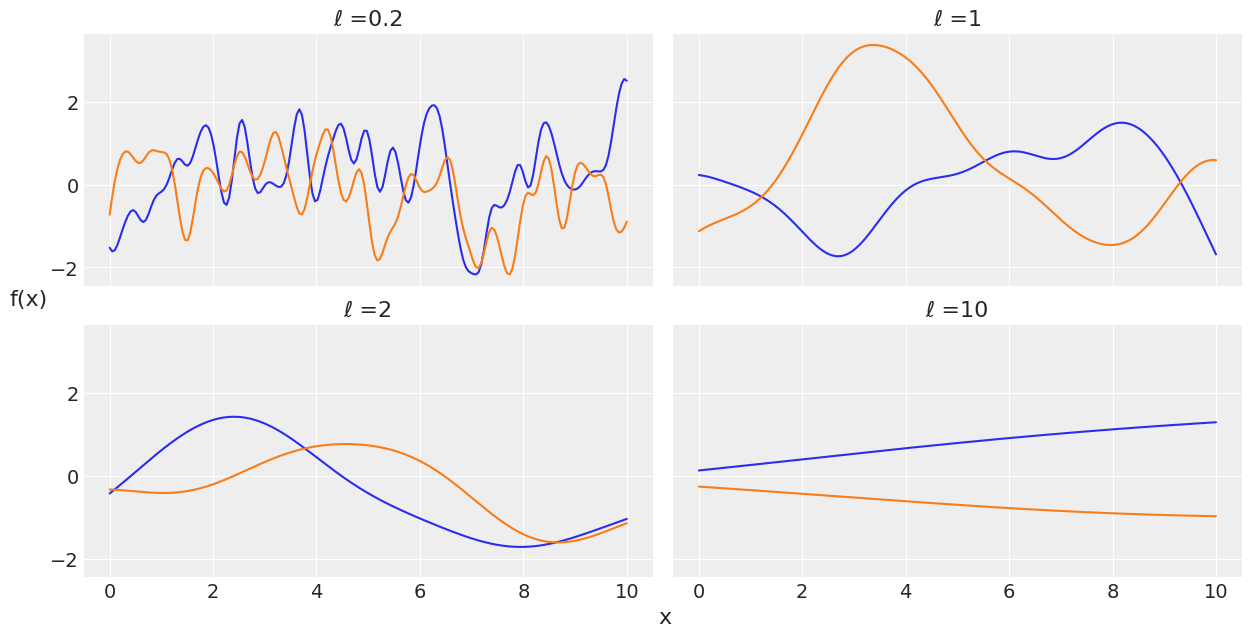

In [5]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True,
                       sharey=True, constrained_layout=True)
ax = np.ravel(ax)
# 四种核宽度
for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    # 四种核函数生成的协方差矩阵
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    
    # 基于协方差矩阵从多维高斯分布中抽样
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov,
size=2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)

<center>

 ![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505203247_f6.webp)

图7.3
</center>

如图 7.3 所示，高斯核蕴含了多个函数，通过超参数 $\ell$ 控制函数的平滑度。$\ell$ 的值越大，函数越平滑。

### 7.2.3 高斯过程

了解对函数建模的原理后，就可以进一步理解什么是高斯过程以及其应用了。从维基百科摘取的对高斯过程的一个比较正式的定义如下：

```{note}
按时间或空间索引的随机变量集合，这些随机变量的每个有限集合都服从多维高斯分布，亦即这些随机变量的每个有限的线性组合服从正态分布。
```

理解高斯过程的诀窍是理解 高斯过程的概念仅仅是一个数学定义，在实践中实际不需要处理无限数学对象。相反，我们只对有数据的地方使用高斯过程。即将所有数据点视为来自多维高斯分布中的某一维的抽样，从而将无限维高斯过程压缩成一个有限维的多维高斯分布。从数学上讲，这种压缩是由无限不可观测维度上的边际化造成的，并且在理论上得到了证明（此处略）。该方法还保证将始终能够得到一个多维高斯分布。因此，可以将图 7.3 解释为来自高斯过程的真实样本！

注意：此处将多维高斯函数的平均值设置为零（即零均值假设），并通过指数族二次核构建了协方差矩阵，进而对函数进行建模。在使用高斯过程时，做出零均值假设是较为常见的做法。

```{note}
高斯过程对于构建贝叶斯非参数模型非常有用，因为可以将它们用作函数的先验分布。
```

##  7.3 高斯过程回归

假设可以将 $y$ 值建模为一个有关于 $x$ 的函数 $f（x）$ 和加性噪声的高斯分布：

```{math}
y \sim \mathcal{N}(\mu=f(x), \sigma=\epsilon) \tag{式7.5} \label{式7.5}
```

此处 $\epsilon \sim \mathcal{N}\left(0, \sigma_{\epsilon}\right)$

这类似于我们在第 3 章“线性回归模型”中所做的假设。主要区别在于，现在将在 $f$ 上配置高斯先验：

```{math}
f(x) \sim \mathcal{G} \mathcal{P}\left(\mu_{x}, K\left(x, x^{\prime}\right)\right) \tag{式7.6} \label{式7.6}
```

这里，$\mathcal{GP}$ 表示高斯过程分布， $\mu_x$ 为均值函数， $K(x,x')$ 为核（或协方差）函数。我们用 `函数` 这个词来表示，在数学上是指均值和协方差都是无限的对象，尽管实践中总是作为有限对象处理。

如果先验分布是高斯过程分布，且似然是正态分布，那么后验分布也是高斯过程分布，我们可以解析地计算它：

```{math}
\begin{align*} 
p\left(f\left(X_{*}\right) \mid X_{*}, X, y\right) &\sim \mathcal{N}(\mu, \Sigma) \tag{式7.7}  \label{式7.7}\\
\mu&=K_{*}^{T} K^{-1} y \tag{式7.8} \label{式7.8}\\
\Sigma &=K_{* *}-K_{*}^{T} K^{-1} K_{*} \notag
\end{align*}
```

这里：

```{math}
\begin{align*}
&\text { - } K=K(X, X) \\
&\text { - } K_{*}=K\left(X_{*}, X\right) \\
&\text { - } K_{* *}=K\left(X_{*}, X_{*}\right)
\end{align*}
```

$X$ 是观察到的数据点，$X_*$ 表示测试点；也就是我们希望知道推断函数值的新点。

像往常一样，PyMC3 自动完成整个推断过程，高斯过程也不例外。因此，让我们继续创建一些数据，然后创建一个 PyMC3 模型：

Text(0, 0.5, 'f(x)')

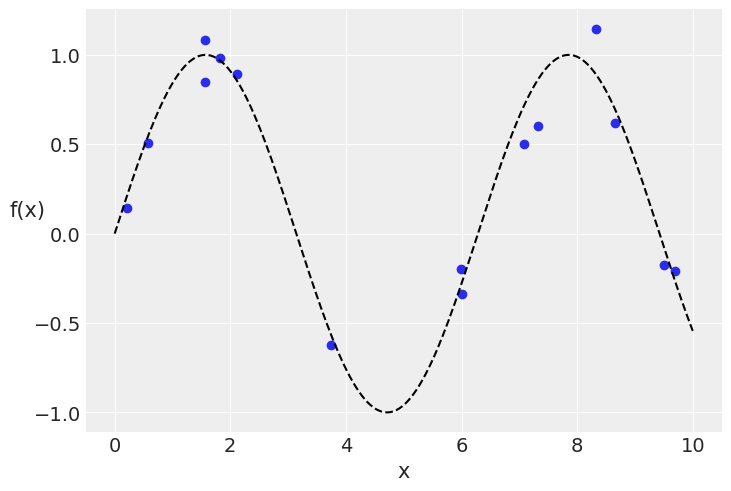

In [6]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505204212_c1.webp)

图7.4 
</center>

在图 7.4 中，我们看到真正的未知函数是一条黑虚线，而点表示未知函数的样本（带有噪声）。

请注意，为了将公式 7.7 和 7.8 编码到 PyMC3 模型中，我们需要设置指数族二次核的 $\epsilon$ 参数、核宽 $\ell$ 和正态似然方差。

高斯过程在 PyMC3 中实现为一系列 Python 类，与以前的模型略有不同；然而，代码仍然非常 `PyMC3onic`。我在以下代码中添加了一些注释，以指导您完成使用 PyMC3 定义高斯过程的关键步骤：

In [7]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)

    trace_reg = pm.sample(2000)

/tmp/ipykernel_3355/2934940681.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_reg = pm.sample(2000)
Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

请注意，我们使用的不是表达式 7.7 中预期的正态似然，而是 `gp.marginal_likelihood` 方法。在第一章“概率思维”（公式 1.1) 和第五章“模型比较”（公式 5.13) 中，边际似然是似然和先验的积分：

```{math}
p(y \mid X, \theta) \sim \int p(y \mid f, X, \theta) p(f \mid X, \theta) df \tag{式7.9} \label{式7.9}
```

与往常一样，$\theta$ 表示所有未知参数，$X$ 是预测变量，$y$ 是结果变量。请注意，我们正在对函数 $f$ 的值进行边际化。对于高斯过程先验和正态似然，可以解析地执行边际化。

根据 PyMC3 的核心开发者、GP 模块的主要贡献者 Bill Engels 的说法，对于核宽度参数，避免采用零先验通常效果更好。$\ell$ 的一个有用默认设置是 `pm.Gamma(2，0.5)`。你可以从 [Stan team](https://github.com/stan-dev/stan/wiki/Prior-ChoiceRecommendations) 阅读更多关于默认有用先验的建议。

In [ ]:
az.plot_trace(trace_reg)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505204431_42.webp)

图 7.5
</center>

现在已经找到 $\ell$ 和 $\epsilon$ 的值，我们可能想要从高斯过程分布的后验中获取样本；即已与数据拟合的函数的样本。通过使用 `gp.conditional` 条件函数计算新输入位置的条件分布来实现这一点：

In [ ]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]
with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

结果得到了一个新的 PyMC3 随机变量 f_pred，我们可以使用它从后验预测分布中获取样本（基于 X_new 值计算）：

In [ ]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, vars=[f_pred],samples=82)

现在可以在原始数据上绘制拟合函数图，以直观检查它们与数据的拟合程度以及预测中的相关不确定性：

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505204540_3f.webp" style="zoom:67%;" />

图 7.6
</center>

或者，我们可以使用 `pm.gp.util.plot_gp_dist` 函数来获得一些不错的绘图。每个绘图代表一个百分位数，范围从 51（浅色）到 99（深色）：

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new,
palette='viridis', plot_samples=False);
ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505204617_c7.webp)

图 7.7
</center>

另一种选择是计算在参数空间中给定点评估的条件分布的平均向量和标准差。在下面的示例中，我们使用 $\ell$ 和 $\epsilon$ 的平均值（在迹的样本上）。我们可以使用 `gp.predict` 函数计算平均值和方差。我们之所以能做到这一点，是因为 PyMC3 已经解析地计算了后验结果：

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
point = {'ℓ': trace_reg['ℓ'].mean(), 'ϵ': trace_reg['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)
ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505204701_d1.webp)

图 7.8
</center>

正如第四章“广义线性模型”中看到的，可以使用具有非高斯似然的线性模型和适当的逆连接函数来扩展线性模型的范围。我们可以为高斯过程做同样的事情。例如，可以使用具有指数逆连接函数的泊松似然。对于这样的模型，后验不再是可分析的，但可以用数值方法来逼近它。

## 7.4 空间自相关回归

下面的例子取自理查德·麦克雷思 (Richard McElreath) 的“统计反思”(Statistics Reink) 一书。我强烈推荐你读他的书，因为你会发现很多像这样的好例子和非常好的解释。唯一需要注意的是，书中的示例是 R/stan 格式的，但请不要担心；您可以在 https://github.com/pymc-devs/Resources 中找到这些示例的 Python/PyMC3 版本。

现在回到例子，我们有 10 个不同的岛屿社会；每一个都有其使用的工具数量。一些理论预测，较大人口需要开发和维护更多工具；另一个重要因素是人群间的接触率。

当将工具数量作为结果变量时，可以使用泊松回归并将人口数量作为预测变量。事实上，可以使用人口的对数，因为根据理论真正重要的是人口比例，而不是绝对大小。将接触率包括在模型中的一种方法是收集有关这些岛屿社会在历史上的接触频率，可以考虑创建一个分类变量，如低/高接触率（请下表中的 Contact 列）。另一种方式是使用不同岛屿社会间的距离作为接触率的代理，可以假设距离近的社会会更频繁地接触。

我们通过读取本书附带的 `island_dist.csv` 文件来访问以千公里为单位表示的距离矩阵：

In [ ]:
islands_dist = pd.read_csv('../data/islands_dist.csv',
                           sep=',', index_col=0)
islands_dist.round(1)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505204845_7c.webp)

</center>

主对角线上填满了零,因为岛屿社会自身距离为零。矩阵是对称的，表示从 A 点到 B 点的距离。工具数量和人口规模存储在另一个文件 `islands.csv` 中，该文件也随书一起分发：

In [ ]:
islands = pd.read_csv('../data/islands.csv', sep=',')
islands.head().round(1)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505204920_fd.webp)

</center>

在表中，只列出和使用 culture, total_tools, lat, lon2 和 logpop 列:

In [ ]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

我们要构建的模型是：

```{math}
\begin{align*} 
f &\sim \mathcal{G P}\left([0, \cdots, 0], K\left(x, x^{\prime}\right)\right) \tag{式7.10} \label{式7.10}\\
\mu &\sim \exp (\alpha+\beta x+f) \tag{式7.11} \label{式7.11}\\
y &\sim \operatorname{Poisson}(\mu)\tag{式7.12} \label{式7.12}
\end{align*}
```

这里，我们省略了 $\alpha$ 和 $\beta$ 的前缀，以及核的超先验。 $x$ 是对数人口， $y$ 是工具总数。

与第四章“广义线性模型”中的模型相比，本模型基本上是一个泊松回归模型，此外，线性模型中的 $f$ 项来自高斯过程。为了计算高斯过程的核，我们将使用距离矩阵 `islands_dist`。通过这种方式，将基于距离矩阵有效地纳入相似性度量。由此，将每个岛屿社会的工具数量建模为其地理相似性的函数，而不是假设仅仅是人口规模的结果，而且岛屿社会间没有接触。

此模型（包括之前的模型）类似于 PyMC3 中的以下代码：

In [ ]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    高斯过程= pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)

    trace_islands = pm.sample(1000, tune=1000)

为理解协方差函数的后验分布，可以根据后验分布绘制一些样本：

In [ ]:
trace_η = trace_islands['η']
trace_ℓ = trace_islands['ℓ']
_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)
ax.plot(xrange, np.median(trace_η) *
        np.exp(-np.median(trace_ℓ) * xrange**2), lw=3)
ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_ℓ[::20][:, None] *
xrange**2)).T,
        'C0', alpha=.1)
ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505205145_a6.webp)

图 7.9
</center>

图 7.9 中的粗线是成对岛屿社会间协方差作为距离函数的后验中位数。我们使用中位数是因为 $\ell$ 和 $η$ 的分布非常不对称。可以看到，平均下来协方差没有那么高，在大约 2000 公里处降到了几乎为 0。细线代表不确定性，可以看到有很大的不确定性。

您可能会发现，将 `model_islands` 及其计算出的后验与[参考资料](https:/​/​github.​com/​pymc-​devs/​resources)中的模型 `m_10_10` 进行比较会很有趣。您可能希望使用 `ArviZ` 函数，例如 `az.summary` 或 `az.plot_forest`。 模型 `m_10_10` 类似于 `model_islands`，但不包含高斯过程项。

根据我们的模型，现在继续探索岛屿之间的社会联系有多强。为此，必须将协方差矩阵转换为相关矩阵：

In [ ]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=islands_dist.columns,
columns=islands_dist.columns)
ρ.round(2)

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505205246_9e.webp)

比较明显的是，夏威夷非常独立，因为夏威夷离其他岛屿社会很远。此外，还可以看到 `Malekula(Ml)`、`Tikopia(Ti)` 和 `Santa Cruz(Sc)` 之间高度相关，因为这些社会非常接近，而且有类似数量的工具。

现在我们使用纬度和经度信息来绘制 `岛屿-社会` 的相对位置：

In [ ]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(trace_islands['α'][:, None] +
                     trace_islands['β'][:, None] * log_pop_seq)
_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)
for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)
ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')
az.plot_hpd(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})
for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505205338_5f.webp)

图7.10
</center>

图 7.10 的左侧显示了之前在相对地理位置上下文中计算的岛屿社会间的后验中值相关性线条。有些线条是不可见的，因为使用相关性来设置了线条的不透明度。在右侧，再次显示了后验中值相关性，但此次是根据对数人口与工具数量绘制的。虚线表示工具的中位数和 94%HPD 间隔作为对数填充的函数。两幅图中，圆点大小与每个岛屿社会的人口成正比。

请注意 `Malekula`、`Tikopia` 和 `Santa Cruz` 之间的相关性如何描述这样一个事实，即它们拥有的工具数量相当少，接近或低于其人口的预期工具数量。类似的事情正发生在`Trobriands`和 `Manus`；它们地理位置相近，拥有的工具比预期人口规模要少。`Tonga` 为其人口提供的工具比预期要多得多，而且与 `Fiji` 的相关性较高。在某种程度上，该模型告诉我们，`Tonga`对 `Lua Fiji`有积极的影响，增加了工具总数，抵消了 `Malekula`、`Tikopia` 和 `Santa Cruz`等近邻对 `Fiji` 的影响。


## 7.5 高斯过程分类

高斯过程不限于回归，也可以用于分类。正如第 4 章“广义线性模型”中所述，通过使用 Logistic 逆连接函数的伯努利似然，将线性模型转化为适合分类的模型。对于iris数据集，本节将尝试重述第 4 章“广义线性模型”中的 model_0，不过这次使用高斯过程而不是线性模型。

In [ ]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

<center>

![image-20210505205534881](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505205541_6c.webp)

</center>

我们从最简单的分类问题开始：类别只有两类：山鸢尾和变色鸢尾；预测变量只有一个：萼片长度。使用数字 0 和 1 对分类变量山鸢尾和变色鸢尾进行编码：

In [ ]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

对于此模型，我们不使用 `pm.gp.Marginal` 类实例化高斯过程先验，而是使用 `pm.gp.Latent` 类。前者仅限于高斯似然，不过通过高斯过程先验与高斯似然具有更高效率，而后者更通用些，可与任何似然一起使用：

In [ ]:
with pm.Model() as model_iris:
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    高斯过程= pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)

    trace_iris = pm.sample(1000, chains=1,compute_convergence_checks=False)

现在我们已经找到了 $\ell$ 的值 ，想要从高斯过程后验获取样本。与 `marginal_gp_model` 的操作一样，可以借助 `gp.conditional` 函数计算一组新输入位置上的条件分布，如以下代码所示：

In [ ]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with model_iris:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(
        trace_iris, vars=[f_pred], samples=1000)

为显示此模型结果，创建一个类似于图 4.4 的图。我们将使用以下函数直接从 `f_pred` 计算决策边界，而不是解析地获得决策边界：

In [ ]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

以下代码与第 4 章“广义线性模型”中用于生成图 4.4 的代码非常相似：

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))
fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)
ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])
az.plot_hpd(X_new[:, 0], fp, color='C2')
db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_11.png')

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505205739_e4.webp)

图 7.11
</center>

图 7.11 与图 4.4 非常相似， `f_pred` 曲线看起来像是一条 S 型曲线，除尾部在较低的 x_1 值时上升，在较高的 x_1 值下降。这是没有数据时预测函数向前移动的结果。如果只关心决策边界，这应该不是真正的问题，但如果想要为不同萼片长度值建立属于山鸢尾或变色鸢尾的概率模型，那么应该改进模型，并做一些事情来获得更好的尾部模型。实现此目标的方法是给高斯过程增加更多的构造。获得更好的高斯过程模型的一般方法是组合协方差函数，以便更好地捕捉函数细节。

以下模型 (`model_iris2`) 与 `model_iris` 相同，不同之处在于协方差矩阵，为三个核的组合：

In [ ]:
cov = K_{ExpQuad} + K_{Linear} + K_{whitenoise}(1E-5)

通过添加线性核修复了尾部问题，如图 7.12 所示。白噪声核只是一个稳定协方差矩阵计算的技巧。对高斯过程的核进行限制，确保得到的协方差矩阵为正定的。但数字误差可能会导致违反此条件，其表现是在计算拟合函数的后验预测样本时会出现无效值（NaN）。通过添加一点噪声来稳定计算能够减轻此问题。其实 PyMC3 已经在幕后做到了这一点，但有时需要更多噪声，如以下代码所示：

In [ ]:
with pm.Model() as model_iris2:
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    高斯过程= pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris2 = pm.sample(1000, chains=1,compute_convergence_checks=False)

现在为先前生成的 `X_new` 值生成 `model_iris2` 的后验预测样本：

In [ ]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris2,
                                                  vars=[f_pred],
                                                  samples=1000)
_, ax = plt.subplots(figsize=(10,6))
fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)
ax.scatter(x_1, np.random.normal(y, 0.02), marker='.',
           color=[f'C{ci}' for ci in y])
db = np.array([find_midpoint(f, X_new[:,0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)
ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hpd(X_new[:,0], fp, color='C2')
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505205912_68.webp)

图 7.12
</center>

图 7.12 看起来更类似于图 4.4，而不是图 7.11。此示例有两个主要目的：

- 展示如何轻松组合核以获得更具表现力的模型
- 展示了如何使用高斯过程实现 Logistic 回归

尤其是第二点，Logistic 回归确实是高斯过程的特例，因为一元线性回归是高斯过程的特例。事实上，许多已知的模型都可以被视为高斯过程的特例，或者至少以某种方式与高斯过程联系在一起。你可以阅读凯文·墨菲 (Kevin Murphy) 的《 Machine Learning: A Probabilistic Perspective 》中的第 15 章。

实践中，使用高斯过程对只能用 Logistic 回归来解决的问题进行建模没有太大意义。相反，我们希望使用高斯过程来建模更复杂的数据，而这些数据使用灵活性较低的模型无法很好地捕获。例如，假设想要将患病概率建模为年龄的函数。事实证明，非常年轻和非常年长的人比中年人有更高风险。数据集 `space_flu.csv` 是受前面描述启发的假数据集。

In [ ]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu
ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505210018_ba.webp)

图7.13
</center>

以下模型与 `model_iris` 基本相同：

In [ ]:
with pm.Model() as model_space_flu:
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    高斯过程= pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)

    trace_space_flu = pm.sample(1000, chains=1, compute_convergence_checks=False)

现在，为 `model_space_flu` 生成后验预测样本，然后绘制结果：

In [ ]:
X_new = np.linspace(0, 80, 200)[:, None]
with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_space_flu,
                                                  vars=[f_pred],
                                                  samples=1000)
_, ax = plt.subplots(figsize=(10, 6))
fp = logistic(pred_samples['f_pred'])
fp_mean = np.nanmean(fp, 0)
ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])
ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)
az.plot_hpd(X_new[:, 0], fp, color='C2')
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')

<center>

![image-20210505210106544](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505210109_bb.webp)

图 7.14
</center>

图 7.14 中，高斯过程能够很好地适应此数据集，即使数据要求函数比逻辑函数更复杂。对于一元逻辑回归来说，很好地拟合该数据是不可能的，除非引入一些特殊的修改来帮助它。

##  7.6 考克斯 （Cox） 过程 

现在考虑计数类数据的建模问题。在此将看到两个示例；一个具有时变计数，另一个具有 2D 空间计数。为做到这点，使用泊松分布对似然建模（每个数据点来自于一个泊松分布的抽样），使用高斯过程对计数函数建模（所有数据点计数的集合来自一个高斯过程的抽样）。因泊松分布的计数被限制为正值，所以我们将使用指数函数作为逆连接函数，类似第 4 章 “广义线性模型” 中的零膨胀泊松回归。

在很多资料中，可变计数也以强度名称出现，此类型问题统称为强度估计问题，此类型的模型则被称为考克斯（Cox）模型。考克斯模型是泊松过程的一种，其计数本身就是一个随机过程。正如高斯过程是随机变量的集合，而且这些随机变量的每个有限集合都具有多维高斯分布一样，泊松过程也是随机变量集合，其中这些随机变量的每个有限集合都具有泊松分布。当泊松过程的计数本身是一个随机过程（如高斯过程）时，称之为考克斯（Cox）过程。

### 7.6.1 煤矿灾害

第一个例子是煤矿灾难。该案例包括英国从 1851 年到 1962 年的煤矿灾难记录。灾难数量被认为受到安全法规变化的影响。我们希望将灾害率建模为时间的函数，数据集只有一列，每个条目都对应灾难发生的时间。让我们加载数据并查看它的一些值：

In [ ]:
coal_df = pd.read_csv('../data/coal.csv', header=None)
coal_df.head()

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505210251_00.webp)

</center>

我们用来拟合上表 `coal_df` 中数据的模型是：

```{math}
\begin{align*}
f(x)  &\sim \mathcal{G P}\left(\mu_{x}, K\left(x, x^{\prime}\right)\right) \tag{式7.13} \label{式7.13} \\
y  &\sim \operatorname{Poisson}(f(x)) \tag{式7.14} \label{式7.14}
\end{align*}
```

公式 $(7.13)$ 、$(7.14)$ 是一个泊松回归问题。你可能会想，如果只有灾难发生日期这一列，将如何执行回归？答案是将数据离散化，就像正在构建直方图一样。我们使用抽屉的中心值作为自变量 $x$ , 每个抽屉内的计数作为因变量 $y$：

In [ ]:
# discretize data
years = int(coal_df.max().values - coal_df.min().values)
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

现在用 PyMC3 定义并求解该模型：

In [ ]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    高斯过程= pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)
    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    
    trace_coal = pm.sample(1000, chains=1)

绘制结果图：

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))
f_trace = np.exp(trace_coal['f'])
rate_median = np.median(f_trace, axis=0)
ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hpd(x_centers, f_trace)
az.plot_hpd(x_centers, f_trace, credible_interval=0.5,
            plot_kwargs={'alpha': 0})
ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505210433_70.webp)

图 7.15
</center>

图 7.15 用白线显示了灾害计数的中位数与时间的关系。这些条带表示 50%HPD 区间（较深）和 94%HPD 区间（较浅）。在底部，用黑色记号笔标出了每一场灾难（这被称为地毯图）。如图所示，除最初的短暂上升外，事故计数随时间的推移而下降。PyMC3 的文档中包括煤矿灾难这个案例，但从不同角度建的模。建议您检查下该示例，因为其本身非常有用，而且将其与刚刚使用 `model_coal` 模型实现的方法进行比较也很有用。

请注意，将数据装入了抽屉后，会得到一条平滑的曲线。从该意义上说，可将 `model_coal`看作是构建了一个直方图，并对其做了平滑。

### 7.6.2 红杉数据集

第二个案例是面向二维空间的红杉木数据。该数据集来自 `GPStuff` 包（一个用于 Matlab、Octave 和 R 的高斯过程包）。该数据集由给定区域上红杉树的位置组成。推断目的是找出该地区树木计数是如何分布的。

像往常一样，我们加载数据并绘制它：

In [ ]:
rw_df = pd.read_csv('../data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505210601_88.webp)

图 7.16
</center>

同煤矿灾难示例类似，需要对数据进行离散化：

In [ ]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

请注意，我们将 x1 和 x2 数据视为分开的数据，而不是mesh网格。这允许我们为每个坐标构建协方差矩阵，从而减小计算高斯过程所需矩阵的大小。在使用 `LatentKron` 类定义高斯过程时，需要注意，这不是一个数字技巧，而是这类矩阵结构的数学属性，因此我们不会在模型中引入任何近似或误差，而只是用一种更快的计算方式来表达它：

In [ ]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ',  rw_df.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])
    高斯过程= pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)
    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)

    trace_rw = pm.sample(1000)

最后，绘制结果图：

In [ ]:
rate = np.exp(np.mean(trace_rw['f'], axis=0).reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505210705_b5.webp)

图 7.17
</center>

图 7.17 中，较浅的颜色意味着比较深颜色有更高的树木比率。可以想象，我们对寻找高增长率地区很感兴趣，因为可能对森林是如何从火灾中恢复的感兴趣，或者我们对土壤性质感兴趣，也可以把树木当作代理。

## 7.7 总结

 高斯过程是多维高斯分布向无限维的推广，并且由均值函数和协方差函数完全指定。由于可以在概念上把函数看作无限长的向量，所以可使用高斯过程作为函数的先验。在实践中，通常处理的不是无限大的对象，而是维数与数据点一样多的多维高斯分布。为定义相应的协方差函数，我们使用了适当的参数化核；通过学习这些超参数，最终来描述任意复杂的函数。

 本章中，我们简要介绍了高斯过程，还有很多与之相关的主题需要进一步学习（比如构建一个半参数化模型，将线性模型作为均值函数），或是将两个或者多个核函数组合在一起来描述未知函数，或将高斯过程用于分类任务，或是如何将高斯过程与统计学或者机器学习中的其他模型联系起来。不管怎么说，希望本章对高斯过程的介绍以及本书中一些其他主题的介绍能够激励你阅读、使用和进一步学习贝叶斯统计。


##  7.8 练习

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505210819_20.webp)

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505210830_d3.webp)